In [35]:
import pyspark

from pyspark.sql.functions import udf
from pyspark.sql.functions import lit
from pyspark.sql.functions import sum as pyspark_sum
from pyspark.sql.functions import year
from pyspark.sql.functions import date_format

from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

from pyspark.ml.stat import KolmogorovSmirnovTest
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GBTRegressionModel
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import math 

from functools import reduce

In [2]:
# Load saved ml data from file

import datetime
from pyspark.sql.types import *

ml_input_schema = StructType([StructField("Submit",TimestampType(),True),
                              StructField("BeocatCPUsInUse",IntegerType(),True),
                              StructField("BeocatMemoryInUse",IntegerType(),True),
                              StructField("max(QueueDepth)",IntegerType(),True),
                              StructField("ReqCPUs",IntegerType(),True),
                              StructField("ReqMem",IntegerType(),True),
                              StructField("ReqMinutes",IntegerType(),True),
                              StructField("OwnsResources",BooleanType(),True),
                              StructField("QueueTimeInSec",IntegerType(),True)])

ml_input_df = spark.read.csv(path=r"./data/ml_input_save.csv", schema=ml_input_schema)
ml_input_df.show()

ml_input_df.describe().show()
print("mean queue time: {} ({} seconds)".format(str(datetime.timedelta(seconds=13423)), 13423))
print("std dev queue time: {} ({} seconds)".format(str(datetime.timedelta(seconds=40660)), 40660))
print("min queue time: {} ({} seconds)".format(str(datetime.timedelta(seconds=0)), 0))
print("max queue time: {} ({} seconds)".format(str(datetime.timedelta(seconds=3047684)), 3047684))

+-------------------+---------------+-----------------+---------------+-------+------+----------+-------------+--------------+
|             Submit|BeocatCPUsInUse|BeocatMemoryInUse|max(QueueDepth)|ReqCPUs|ReqMem|ReqMinutes|OwnsResources|QueueTimeInSec|
+-------------------+---------------+-----------------+---------------+-------+------+----------+-------------+--------------+
|2018-01-27 12:32:17|            449|          4883000|             22|     16| 32000|     10080|        false|        108390|
|2018-01-27 23:22:52|            449|          4883000|             38|     16|  1028|      4320|        false|        197710|
|2018-02-01 17:52:50|           5655|         55821582|            170|     20| 20000|     10080|        false|        140789|
|2018-02-01 20:44:25|           5655|         55821582|            193|      1|  1000|      2880|        false|        228869|
|2018-02-02 09:10:15|           5005|         45261670|            171|      4|  4000|      1440|        false|

In [3]:
# Are the columns normally distributed?

print("Null Hypothesis is that this data follows a normal distribution")
stats = KolmogorovSmirnovTest.test(ml_input_df, "QueueTimeInSec", "norm")
stats.show()
print("Low P value means we reject the null hypthesis.  Queue time does not follow a normal distribution.")
print("Queue Time is extremely left skewed, so maybe we're doing something right?")
print()
# How much do columns depend upon one another?
print("Pearson Correlation Coefficient is a value from -1 to 1.")
print("When r = zero, it means that there is no linear association between the variables.")
print("If 0 < r < 1 then there is a positive linear trend and the sampled individuals are scattered around the line of best fit.")

cols = ["BeocatCPUsInUse", "BeocatMemoryInUse", "max(QueueDepth)", "ReqCPUs", "ReqMem", "ReqMinutes"]
for col_name in cols:
    print("How correlated are QueueTimeInSec and on {:17}? {:.5}".format(col_name, ml_input_df.corr("QueueTimeInSec", col_name)))

for col1 in cols:
    for col2 in cols:
        if col1==col2:
            continue
        print("How correlated are {:17} and {:17}? {:.5}".format(col1, col2, ml_input_df.corr(col1, col2)))

Null Hypothesis is that this data follows a normal distribution
+--------------------+-----------------+
|              pValue|        statistic|
+--------------------+-----------------+
|3.798391157161518E-9|0.861054984045061|
+--------------------+-----------------+

Low P value means we reject the null hypthesis.  Queue time does not follow a normal distribution.
Queue Time is extremely left skewed, so maybe we're doing something right?

Pearson Correlation Coefficient is a value from -1 to 1.
When r = zero, it means that there is no linear association between the variables.
If 0 < r < 1 then there is a positive linear trend and the sampled individuals are scattered around the line of best fit.
How correlated are QueueTimeInSec and on BeocatCPUsInUse  ? -0.0090557
How correlated are QueueTimeInSec and on BeocatMemoryInUse? 0.13104
How correlated are QueueTimeInSec and on max(QueueDepth)  ? 0.32636
How correlated are QueueTimeInSec and on ReqCPUs          ? -0.0018619
How correlated 

In [3]:
# Transform data for machine learning

# UDF for converting column type from vector to double type
unlist = udf(lambda x: float(list(x)[0]), DoubleType())

assembler = VectorAssembler(inputCols=["BeocatCPUsInUse"], outputCol="BeocatCPUsInUse_Vect")
thing = assembler.transform(ml_input_df)

scaler = MinMaxScaler(inputCol="BeocatCPUsInUse_Vect", outputCol="BeocatCPUsInUse_Scaled", max=100.0)
thing2 = scaler.fit(thing).transform(thing).withColumn("BeocatCPUsInUse_Scaled", unlist("BeocatCPUsInUse_Scaled")).drop("BeocatCPUsInUse_Vect")

assembler = VectorAssembler(inputCols=["BeocatMemoryInUse"], outputCol="BeocatMemoryInUse_Vect")
thing3 = assembler.transform(thing2)

scaler = MinMaxScaler(inputCol="BeocatMemoryInUse_Vect", outputCol="BeocatMemoryInUse_Scaled", max=100.0)
thing4 = scaler.fit(thing3).transform(thing3).withColumn("BeocatMemoryInUse_Scaled", unlist("BeocatMemoryInUse_Scaled")).drop("BeocatMemoryInUse_Vect")

assembler = VectorAssembler(inputCols=["BeocatCPUsInUse_Scaled",
                                       "BeocatMemoryInUse_Scaled",
                                       "max(QueueDepth)",
                                       "ReqCPUs",
                                       "ReqMem",
                                       "ReqMinutes",
                                       "OwnsResources"], outputCol="features")

thing5 = assembler.transform(thing4).select("features", "QueueTimeInSec")

#get rid of strange first entry
data = thing5.filter(~(thing5.QueueTimeInSec == 70443))

data = data.withColumn("label", data.QueueTimeInSec.cast("Double")).drop("QueueTimeInSec")
data.show(20, truncate=False)


+--------------------------------------------------------------------+--------+
|features                                                            |label   |
+--------------------------------------------------------------------+--------+
|[3.8089148702959448,8.695171797487209,22.0,16.0,32000.0,10080.0,0.0]|108390.0|
|[3.8089148702959448,8.695171797487209,38.0,16.0,1028.0,4320.0,0.0]  |197710.0|
|[51.36097917427841,100.0,170.0,20.0,20000.0,10080.0,0.0]            |140789.0|
|[51.36097917427841,100.0,193.0,1.0,1000.0,2880.0,0.0]               |228869.0|
|[45.42382170259408,81.07189259815569,171.0,4.0,4000.0,1440.0,0.0]   |0.0     |
|[45.42382170259408,81.07189259815569,211.0,12.0,40000.0,5760.0,0.0] |14.0    |
|[44.163317500913415,78.35293334873883,336.0,1.0,1000.0,60.0,0.0]    |34.0    |
|[44.163317500913415,78.35293334873883,314.0,4.0,12000.0,1440.0,0.0] |53.0    |
|[44.163317500913415,78.35293334873883,314.0,4.0,12000.0,1440.0,0.0] |53.0    |
|[44.163317500913415,78.35293334873883,3

In [4]:
# Split data into train and test sets
# seed set for reproducability
train_data, test_data = data.randomSplit([.8, .2], seed=2)
print("Number in train_data = {}".format(train_data.count()))
print("Number in test_data = {}".format(test_data.count()))

Number in train_data = 583710
Number in test_data = 145297


In [6]:
# Train a GBTR model using cross validation using all the data.
# This can take some time (~20-30 mins?)
# This is the GBTR base model which will be used to predict
# clusters which do not have many points.

gbt = GBTRegressor(featuresCol="features", predictionCol="gbt_prediction", maxIter=150)

grid = ParamGridBuilder().baseOn({gbt.featuresCol: "features"}).build()

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="gbt_prediction", metricName="rmse")

cv = CrossValidator(estimator=gbt, estimatorParamMaps=grid, evaluator=evaluator, numFolds=5, parallelism=4, seed=2)
cv_gbt_model = cv.fit(train_data)
pred = cv_gbt_model.transform(test_data)
pred.show()

+--------------------+-------+-------------------+
|            features|  label|     gbt_prediction|
+--------------------+-------+-------------------+
|[3.80891487029594...|43275.0|  70487.47110789112|
|[6.96017537449762...|56027.0|  52295.43964319877|
|[12.3675557179393...|73422.0| 49564.309507610815|
|[12.3675557179393...|73304.0| 49564.309507610815|
|[12.3675557179393...|72163.0| 49564.309507610815|
|[12.3675557179393...|   23.0| 52594.395981446854|
|[12.3675557179393...|54186.0| 20485.551934218787|
|[12.3675557179393...|   25.0|  4178.535611151642|
|[12.3675557179393...|   25.0|  4178.535611151642|
|[12.3675557179393...|61659.0|  34799.48512724743|
|[12.3675557179393...|   10.0| 131.95969182610042|
|[16.1033978808914...|    1.0|-1157.5691923163185|
|[16.1033978808914...|    1.0|  67408.57290111887|
|[17.4826452320058...|    2.0|  9691.828032947718|
|[17.4826452320058...|    5.0| -854.4927811822608|
|[17.4826452320058...|    1.0|-234.05993519915742|
|[19.4556083302886...|    0.0| 

In [7]:
# Save the model so we don't have to compute it again
base_dir = r"./data"
save_path = os.path.join(base_dir, "gbt_base")
cv_gbt_model.save(save_path)
print("Base model saved in {} folder".format(save_path))

Base model saved in ./data/gbt_base folder


In [8]:
# Load a previosly saved model
base_path = r"./data"
load_path = os.path.join(base_path, "gbt_base")

base_model = CrossValidatorModel.load(load_path)
print("base model loaded from {}".format(load_path))

base model loaded from ./data/gbt_base


In [9]:
# Evaluate the performance of the base model
pred = base_model.transform(test_data)
pred.show()

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="gbt_prediction", metricName="rmse")

rmse = evaluator.evaluate(pred)
print("Base model RMSE = {}".format(rmse))

+--------------------+-------+-------------------+
|            features|  label|     gbt_prediction|
+--------------------+-------+-------------------+
|[3.80891487029594...|43275.0|  70487.47110789112|
|[6.96017537449762...|56027.0|  52295.43964319877|
|[12.3675557179393...|73422.0| 49564.309507610815|
|[12.3675557179393...|73304.0| 49564.309507610815|
|[12.3675557179393...|72163.0| 49564.309507610815|
|[12.3675557179393...|   23.0| 52594.395981446854|
|[12.3675557179393...|54186.0| 20485.551934218787|
|[12.3675557179393...|   25.0|  4178.535611151642|
|[12.3675557179393...|   25.0|  4178.535611151642|
|[12.3675557179393...|61659.0|  34799.48512724743|
|[12.3675557179393...|   10.0| 131.95969182610042|
|[16.1033978808914...|    1.0|-1157.5691923163185|
|[16.1033978808914...|    1.0|  67408.57290111887|
|[17.4826452320058...|    2.0|  9691.828032947718|
|[17.4826452320058...|    5.0| -854.4927811822608|
|[17.4826452320058...|    1.0|-234.05993519915742|
|[19.4556083302886...|    0.0| 

In [10]:
#How accurate is just guessing 0 or just guessing the average?
guess_zero = data.select("label").withColumn("zero", lit(0.0)).withColumn("average", lit(13423.21))
guess_zero.show()

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="zero", metricName="rmse")
rmse = evaluator.evaluate(guess_zero)
print("Root Mean Squared Error (RMSE) on for guessing zero is = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="average", metricName="rmse")
rmse = evaluator.evaluate(guess_zero)
print("Root Mean Squared Error (RMSE) on for guessing the average is = %g" % rmse)

+--------+----+--------+
|   label|zero| average|
+--------+----+--------+
|108390.0| 0.0|13423.21|
|197710.0| 0.0|13423.21|
|140789.0| 0.0|13423.21|
|228869.0| 0.0|13423.21|
|     0.0| 0.0|13423.21|
|    14.0| 0.0|13423.21|
|    34.0| 0.0|13423.21|
|    53.0| 0.0|13423.21|
|    53.0| 0.0|13423.21|
|    53.0| 0.0|13423.21|
|    23.0| 0.0|13423.21|
|    23.0| 0.0|13423.21|
|    23.0| 0.0|13423.21|
|    43.0| 0.0|13423.21|
|    43.0| 0.0|13423.21|
|    44.0| 0.0|13423.21|
|    44.0| 0.0|13423.21|
|    20.0| 0.0|13423.21|
|    20.0| 0.0|13423.21|
|    20.0| 0.0|13423.21|
+--------+----+--------+
only showing top 20 rows

Root Mean Squared Error (RMSE) on for guessing zero is = 42818.2
Root Mean Squared Error (RMSE) on for guessing the average is = 40659.8


In [11]:
# Use K means clustering on the data and then using GBTrees on each cluster
# Using cross validation on GBTregression

# This code first attempts to load a previously saved model.  If one in unavailable, it will generate one.
# If DO_SAVES is set to True, generated models will be saved for later use.

# Depending on how many clusters you want, this can take a very long time

base_dir = r"./data"
DO_SAVES = True

gbt = GBTRegressor(featuresCol="features", predictionCol="gbt_prediction", maxIter=150)
grid = ParamGridBuilder().baseOn({gbt.featuresCol: "features"}).build()
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="gbt_prediction", metricName="rmse")
cv = CrossValidator(estimator=gbt, estimatorParamMaps=grid, evaluator=evaluator, numFolds=5, parallelism=4, seed=2)


# Modify the range here to vary the number of clusters generated.
for num_clusters in range(57,58,1):
    print("Trying to cluster into {} clusters".format(num_clusters))
    gbt_models = []
    
    try:
        kmeans_model = KMeansModel.load(os.path.join(base_dir, "k_means_{}_clusters".format(num_clusters)))
        print("KMeans model with {} clusters loaded from save".format(num_clusters))
    except Exception as e:
        print("Save file not found.  Generating k-means model.")
        kmeans = KMeans().setK(num_clusters).setSeed(1)
        kmeans_model = kmeans.fit(train_data)
        if DO_SAVES:
            kmeans_model.save(os.path.join(base_dir, "k_means_{}_clusters".format(num_clusters)))
    predictions = kmeans_model.transform(train_data)
    #predictions.show(5)
    for i in range(num_clusters):
        cluster = predictions.filter(col("prediction")==i)
        num_in_cluster = cluster.count()
        print("On training data, cluster[{}] has {} elements".format(i, num_in_cluster))
        if num_in_cluster <=100:
            gbt_models.append(base_model)
            #print("cluster[{}] rsme = {}".format(i, rmse))
        else:
            try:
                model = CrossValidatorModel.load(os.path.join(base_dir, "k_means_{}_clusters_gbt_model_{}".format(num_clusters, i)))
                gbt_models.append(model)
                print("Model {} loaded from save".format(i))
                continue
            except Exception as e:
                print(e)
            
                print("cluster[{}] model save file not found.  Generating".format(i))
                cluster_gbt_model = cv.fit(cluster)
                if DO_SAVES:
                    cluster_gbt_model.save(os.path.join(base_dir, "k_means_{}_clusters_gbt_model_{}".format(num_clusters, i)))
                gbt_models.append(cluster_gbt_model)

    test_clusters = kmeans_model.transform(test_data)
    num_in_test_batch = test_data.count()
    for i in range(num_clusters):
        cluster = test_clusters.filter(col("prediction")==i)
        num_in_cluster = cluster.count()
        if num_in_cluster == 0:
            continue
        cluster_gbt_pred = gbt_models[i].transform(cluster)
        rmse = evaluator.evaluate(cluster_gbt_pred)
        print("On test data, cluster[{}] has {} elements with rsme of {}".format(i, num_in_cluster, rmse))


Trying to cluster into 57 clusters
KMeans model with 57 clusters loaded from save
On training data, cluster[0] has 15850 elements
Model 0 loaded from save
On training data, cluster[1] has 5 elements
On training data, cluster[2] has 2 elements
On training data, cluster[3] has 286 elements
Model 3 loaded from save
On training data, cluster[4] has 17089 elements
Model 4 loaded from save
On training data, cluster[5] has 2 elements
On training data, cluster[6] has 2625 elements
Model 6 loaded from save
On training data, cluster[7] has 626 elements
Model 7 loaded from save
On training data, cluster[8] has 9635 elements
Model 8 loaded from save
On training data, cluster[9] has 23335 elements
Model 9 loaded from save
On training data, cluster[10] has 137 elements
Model 10 loaded from save
On training data, cluster[11] has 3 elements
On training data, cluster[12] has 1 elements
On training data, cluster[13] has 98205 elements
Model 13 loaded from save
On training data, cluster[14] has 21 elemen

In [11]:
# RMSE calculation
# This process can also take a while

base_dir = r"./data"
num_in_test_data = test_data.count()

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

base_model = CrossValidatorModel.load(os.path.join(base_dir, "gbt_base"))
print("base model loaded")

for num_clusters in range(57, 58):
    kmeans_model = KMeansModel.load(os.path.join(base_dir, "k_means_{}_clusters".format(num_clusters)))
    print("k means model for {} cluters loaded".format(num_clusters))
    gbt_models = []

    for i in range(num_clusters):
        current_model_dir = os.path.join(base_dir, "k_means_{}_clusters_gbt_model_{}".format(num_clusters, i))
        if(os.path.isdir(current_model_dir)):
            model = CrossValidatorModel.load(current_model_dir)
            gbt_models.append(model)
            #print("Model {} loaded".format(i))
        else:
            gbt_models.append(base_model)
            #print("Model {} not found.  Using base model".format(i))

    print("{} models loaded".format(len(gbt_models)))
    cluster_pred = kmeans_model.transform(test_data)

    clusters = []
    for i in range(num_clusters):
        cluster = cluster_pred.filter(col("prediction")==i)
        gbt_pred = gbt_models[i].transform(cluster)
        clusters.append(gbt_pred)

    print("Predictions made.  Evaluating.")
    all_gbt_preds = unionAll(*clusters)
    squared_error = all_gbt_preds.withColumn("squared_error", (col("label") - col("gbt_prediction"))**2)
    squared_error_sum = squared_error.agg(pyspark_sum(col("squared_error"))).collect()[0][0]
    rmse = math.sqrt(squared_error_sum/num_in_test_data)
    print("For {} clusters, rmse is {}\n".format(num_clusters, rmse))

base model loaded
k means model for 57 cluters loaded
57 models loaded
Predictions made.  Evaluating.
For 57 clusters, rmse is 15223.785053227544



In [14]:
# Assign a deadline and see if our predictions exceeded the deadline or not

#deadline of the average queue time = 13423.21
with_deadline = all_gbt_preds.withColumn("deadline", lit(13423.21)).select("label", "gbt_prediction", "deadline")

#deadline of the one hour
#with_deadline = all_gbt_preds.withColumn("deadline", lit(3600)).select("label", "gbt_prediction", "deadline")

#deadline of 12 hours
#with_deadline = all_gbt_preds.withColumn("deadline", lit(43200)).select("label", "gbt_prediction", "deadline")

#deadline of 8 hours
#with_deadline = all_gbt_preds.withColumn("deadline", lit(28800)).select("label", "gbt_prediction", "deadline")

with_deadline.show()
true_positives = with_deadline.filter( (col("label")<=col("deadline")) & (col("gbt_prediction")<=col("deadline")))
true_negatives = with_deadline.filter( (col("label")>col("deadline")) & (col("gbt_prediction")>col("deadline")))
false_positives = with_deadline.filter( (col("label")>col("deadline")) & (col("gbt_prediction")<=col("deadline")))
false_negatives = with_deadline.filter( (col("label")<=col("deadline")) & (col("gbt_prediction")>col("deadline")))

print("TP - Model predicts jobs starts before deadline and it does")
true_positives.show(10)

print("TN - Model predicts jobs starts after deadline and it does")
true_negatives.show(10)

print("FP - Model predicts jobs starts before deadline but it actually starts after")
false_positives.show(10)

print("FN- Model predicts jobs starts after deadline it actually starts before")
false_negatives.show(10)

+------+------------------+--------+
| label|    gbt_prediction|deadline|
+------+------------------+--------+
|   2.0| 8.827708703614928|13423.21|
|   2.0| 8.827708703614928|13423.21|
|   2.0| 8.827708703614928|13423.21|
|   1.0| 8.827708703614928|13423.21|
|   1.0| 8.827708703614928|13423.21|
|   0.0| 8.827708703614928|13423.21|
|   0.0| 8.827708703614928|13423.21|
|   0.0| 8.827708703614928|13423.21|
|   3.0| 8.827708703614928|13423.21|
|   0.0| 8.762756211582566|13423.21|
|   1.0| 8.762756211582566|13423.21|
|   0.0|-3.605707608635553|13423.21|
|   1.0|-3.605707608635553|13423.21|
|   5.0| 5.384998964796235|13423.21|
|   7.0| 5.384998964796235|13423.21|
|   1.0| 5.264970428388139|13423.21|
|   0.0| 5.264970428388139|13423.21|
|5868.0| 6628.763348353117|13423.21|
|   8.0|31.231091668686187|13423.21|
|   0.0|-55.13466276571342|13423.21|
+------+------------------+--------+
only showing top 20 rows

TP - Model predicts jobs starts before deadline and it does
+-----+-----------------+-

In [15]:
# Generate confusion matrix
TP = true_positives.count()
print("TP count = {}".format(TP))

TN = true_negatives.count()
print("TN count = {}".format(TN))

FP = false_positives.count()
print("FP count = {}".format(FP))

FN = false_negatives.count()
print("FN count = {}".format(FN))

accuracy = (TP + TN)/(TP + TN + FP + FN)
print("Accuracy = {}".format(accuracy))

precision = TP/(TP + FP)
print("precision = {}".format(precision))

recall = TP/(TP+FN)
print("recall is {}".format(recall))

F1_score = (2*TP)/(2*TP + FP + FN)
print("F1 score = {}".format(F1_score))

TP count = 106631
TN count = 33838
FP count = 1509
FN count = 3319
Accuracy = 0.9667715093911092
precision = 0.9860458664693915
recall is 0.9698135516143702
F1 score = 0.9778623504057957


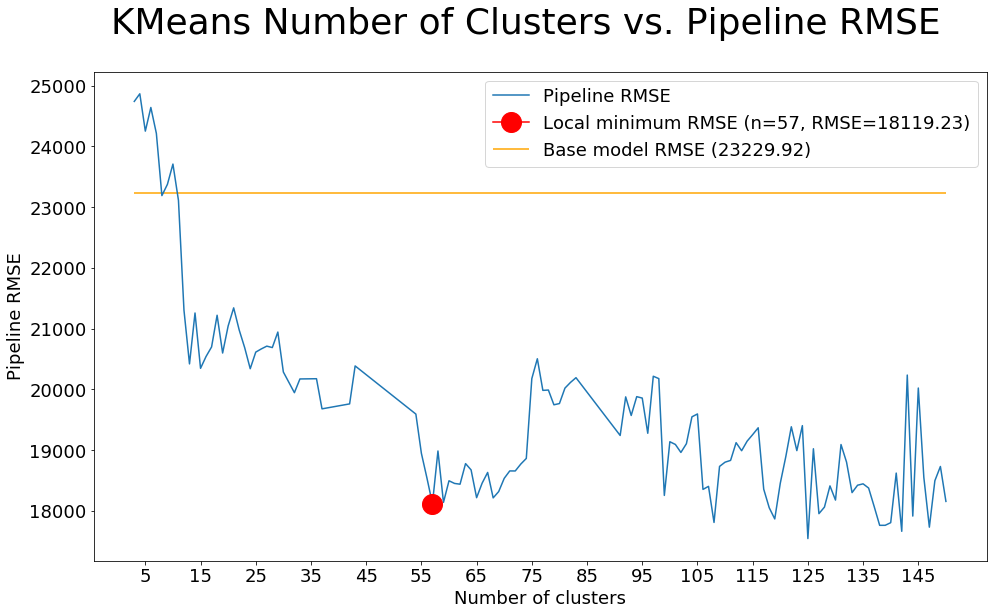

In [16]:
# The RMSE calculation for all the different batches were 
# calculated in parallell using HPC resources with the rmse_calculator.py
# file.  The output from the runs was saved into ./data/rmses_out2.txt
# This process would take a very, very long time to do in serial.

f = open("./data/rmses_out2.txt", "r")
lines = f.readlines()
f.close()

lines = list(map(str.strip, lines))
num_clusters = []
rmses = []
for line in lines:
    elements = line.split()
    try:
        num_clusters.append(int(elements[1]))
        rmses.append(float(elements[5]))
    except ValueError as e:
        continue
    except IndexError as e:
        continue
   
fig = plt.figure(figsize=(16,9))
fig.suptitle("KMeans Number of Clusters vs. Pipeline RMSE", size=36)
plt.plot(num_clusters, rmses, label="Pipeline RMSE")
elbow_cluster = 57
plt.plot([elbow_cluster],
         rmses[num_clusters.index(elbow_cluster)],
         color="red",
         marker="o",
         label="Local minimum RMSE (n={}, RMSE={})".format(elbow_cluster, round(rmses[num_clusters.index(elbow_cluster)], 2)),
         markersize=20)
                                                                                
plt.hlines(23229.92, 3, 150, color="orange", label="Base model RMSE (23229.92)")
plt.xticks(range(5,151, 10), size=18)
plt.yticks(size=18)
plt.xlabel("Number of clusters", size=18)
plt.ylabel("Pipeline RMSE", size=18)
plt.legend(fontsize=18)
#fig.savefig("kmeans_rmse.png")
plt.show()


In [22]:
# Load log file
# This file is ~8 Gb and is not contained in the Repo.
# You won't be able to run this cell or the next two cells
# The code may give you an idea of what I did, though.
job_schema = StructType([StructField("Account",StringType(),True),
                         StructField("AdminComment",StringType(),True),
                         StructField("AllocCPUS",IntegerType(),True),
                         StructField("AllocGRES",StringType(),True),
                         StructField("AllocNodes",IntegerType(),True),
                         StructField("AllocTRES",StringType(),True),
                         StructField("AssocID",IntegerType(),True),
                         StructField("AveCPU",StringType(),True),
                         StructField("AveCPUFreq",StringType(),True),
                         StructField("AveDiskRead",StringType(),True),
                         StructField("AveDiskWrite",StringType(),True),
                         StructField("AvePages",StringType(),True),
                         StructField("AveRSS",StringType(),True),
                         StructField("AveVMSize",StringType(),True),
                         StructField("BlockID",StringType(),True),
                         StructField("Cluster",StringType(),True),
                         StructField("Comment",StringType(),True),
                         StructField("ConsumedEnergy",StringType(),True),
                         StructField("ConsumedEnergyRaw",StringType(),True),
                         StructField("CPUTime",StringType(),True),
                         StructField("CPUTimeRAW",IntegerType(),True),
                         StructField("DerivedExitCode",StringType(),True),
                         StructField("Elapsed",StringType(),True),
                         StructField("ElapsedRaw",IntegerType(),True),
                         StructField("Eligible",TimestampType(),True),
                         StructField("End",TimestampType(),True),
                         StructField("ExitCode",StringType(),True),
                         StructField("GID",IntegerType(),True),
                         StructField("Group",StringType(),True),
                         StructField("JobID",StringType(),True),
                         StructField("JobIDRaw",StringType(),True),
                         StructField("JobName",StringType(),True),
                         StructField("Layout",StringType(),True),
                         StructField("MaxDiskRead",StringType(),True),
                         StructField("MaxDiskReadNode",StringType(),True),
                         StructField("MaxDiskReadTask",StringType(),True),
                         StructField("MaxDiskWrite",StringType(),True),
                         StructField("MaxDiskWriteNode",StringType(),True),
                         StructField("MaxDiskWriteTask",StringType(),True),
                         StructField("MaxPages",StringType(),True),
                         StructField("MaxPagesNode",StringType(),True),
                         StructField("MaxPagesTask",StringType(),True),
                         StructField("MaxRSS",StringType(),True),
                         StructField("MaxRSSNode",StringType(),True),
                         StructField("MaxRSSTask",StringType(),True),
                         StructField("MaxVMSize",StringType(),True),
                         StructField("MaxVMSizeNode",StringType(),True),
                         StructField("MaxVMSizeTask",StringType(),True),
                         StructField("McsLabel",StringType(),True),
                         StructField("MinCPU",StringType(),True),
                         StructField("MinCPUNode",StringType(),True),
                         StructField("MinCPUTask",StringType(),True),
                         StructField("NCPUS",IntegerType(),True),
                         StructField("NNodes",IntegerType(),True),
                         StructField("NodeList",StringType(),True),
                         StructField("NTasks",StringType(),True),
                         StructField("Priority",IntegerType(),True),
                         StructField("Partition",StringType(),True),
                         StructField("QOS",StringType(),True),
                         StructField("QOSRAW",IntegerType(),True),
                         StructField("ReqCPUFreq",StringType(),True),
                         StructField("ReqCPUFreqMin",StringType(),True),
                         StructField("ReqCPUFreqMax",StringType(),True),
                         StructField("ReqCPUFreqGov",StringType(),True),
                         StructField("ReqCPUS",IntegerType(),True),
                         StructField("ReqGRES",StringType(),True),
                         StructField("ReqMem",StringType(),True),
                         StructField("ReqNodes",IntegerType(),True),
                         StructField("ReqTRES",StringType(),True),
                         StructField("Reservation",StringType(),True),
                         StructField("ReservationId",StringType(),True),
                         StructField("Reserved",StringType(),True),
                         StructField("ResvCPU",StringType(),True),
                         StructField("ResvCPURAW",IntegerType(),True),
                         StructField("Start",TimestampType(),True),
                         StructField("State",StringType(),True),
                         StructField("Submit",TimestampType(),True),
                         StructField("Suspended",StringType(),True),
                         StructField("SystemCPU",StringType(),True),
                         StructField("SystemComment",StringType(),True),
                         StructField("Timelimit",StringType(),True),
                         StructField("TimelimitRaw",IntegerType(),True),
                         StructField("TotalCPU",StringType(),True),
                         StructField("TRESUsageInAve",StringType(),True),
                         StructField("TRESUsageInMax",StringType(),True),
                         StructField("TRESUsageInMaxNode",StringType(),True),
                         StructField("TRESUsageInMaxTask",StringType(),True),
                         StructField("TRESUsageInMin",StringType(),True),
                         StructField("TRESUsageInMinNode",StringType(),True),
                         StructField("TRESUsageInMinTask",StringType(),True),
                         StructField("TRESUsageInTot",StringType(),True),
                         StructField("TRESUsageOutAve",StringType(),True),
                         StructField("TRESUsageOutMax",StringType(),True),
                         StructField("TRESUsageOutMaxNode",StringType(),True),
                         StructField("TRESUsageOutMaxTask",StringType(),True),
                         StructField("TRESUsageOutMin",StringType(),True),
                         StructField("TRESUsageOutMinNode",StringType(),True),
                         StructField("TRESUsageOutMinTask",StringType(),True),
                         StructField("TRESUsageOutTot",StringType(),True),
                         StructField("UID",IntegerType(),True),
                         StructField("User",StringType(),True),
                         StructField("UserCPU",StringType(),True),
                         StructField("WCKey",StringType(),True),
                         StructField("WCKeyID",IntegerType(),True),
                         StructField("WorkDir",StringType(),True)])

all_jobs = spark.read.csv("/homes/scotthutch/beocat_slurm_raw.csv", sep="|", header=True, schema=job_schema)
print("Total number of jobs in the log is {}".format(all_jobs.count()))

base_jobs = all_jobs.filter(year(all_jobs.Submit)==2018).filter(~(all_jobs.JobID.contains("_")) & ~(all_jobs.JobID.contains(".")))
base_jobs_with_submit_date = base_jobs.withColumn("SubmitDate", date_format(base_jobs.Submit, "yyyy-MM-dd"))

print("Found {} jobs".format(base_jobs.count()))
base_jobs_with_submit_date.head()

Total number of jobs in the log is 10984901
Found 729008 jobs


Row(Account='beodefault', AdminComment=None, AllocCPUS=32, AllocGRES=None, AllocNodes=1, AllocTRES='cpu=32,mem=64G,node=1', AssocID=1076, AveCPU=None, AveCPUFreq=None, AveDiskRead=None, AveDiskWrite=None, AvePages=None, AveRSS=None, AveVMSize=None, BlockID=None, Cluster='beocat', Comment=None, ConsumedEnergy=None, ConsumedEnergyRaw=None, CPUTime='1-09:32:48', CPUTimeRAW=120768, DerivedExitCode='0:0', Elapsed='01:02:54', ElapsedRaw=3774, Eligible=datetime.datetime(2018, 2, 28, 11, 22, 12), End=datetime.datetime(2018, 2, 28, 12, 25, 10), ExitCode='0:0', GID=2655, Group='vtuoc_users', JobID='226781', JobIDRaw='226781', JobName='SnS-31N', Layout=None, MaxDiskRead=None, MaxDiskReadNode=None, MaxDiskReadTask=None, MaxDiskWrite=None, MaxDiskWriteNode=None, MaxDiskWriteTask=None, MaxPages=None, MaxPagesNode=None, MaxPagesTask=None, MaxRSS=None, MaxRSSNode=None, MaxRSSTask=None, MaxVMSize=None, MaxVMSizeNode=None, MaxVMSizeTask=None, McsLabel=None, MinCPU=None, MinCPUNode=None, MinCPUTask=None,

In [23]:
# This cell won't run, as it relies upon a log file not contained in the repo.
# The code may give you an idea of what I did, though.

@udf
def get_queue_time(start_time, submit_time):
    return (start_time - submit_time).seconds

@udf
def get_mem(tres_string):
    if tres_string is None:
        return 1000
    elements = tres_string.split(",")
    for element in elements:
        if "mem" in element:
            label, value = element.split("=")
            if "G" in value:
                return math.ceil(float(value.strip("G"))) * 1000
            elif "M" in value:
                return math.ceil(float(value.strip("M")))
            elif "T" in value:
                return math.ceil(float(value.strip("T"))) * 1000000
            else:
                return 1000

queue_times = base_jobs.select("Submit", "Start", "End", "AllocTRES", "ReqCPUs", "TimeLimitRaw").withColumn("QueueTime", get_queue_time(col("Start"), col("Submit")))
mem_values = queue_times.withColumn("ReqMem", get_mem(col("AllocTRES"))).drop("AllocTRES").withColumn("ReqMinutes", col("TimeLimitRaw")).drop("TimeLimitRaw")
start_jobs = mem_values.withColumn("Event", lit("Start")).withColumn("Time", col("Start"))
end_jobs = mem_values.withColumn("Event", lit("End")).withColumn("Time", col("End"))

combined_jobs = start_jobs.union(end_jobs)
ordered_combined_jobs = combined_jobs.sort(col("Time"))
ordered_combined_jobs.show()

job_list = ordered_combined_jobs.select("Event", "Time", "ReqCPUs", "ReqMem", "QueueTime").collect()

cpus_in_use = 0
mem_in_use = 0

job_list_beo = []

for index, row in enumerate(job_list):
    if row.Event == "Start":
        cpus_in_use += row.ReqCPUs
        mem_in_use += int(row.ReqMem)
        new_job_tuple = (row.Event, row.Time, row.ReqCPUs, int(row.ReqMem), cpus_in_use, mem_in_use, int(row.QueueTime))
        job_list_beo.append(new_job_tuple)
    elif row.Event == "End":
        cpus_in_use = row.ReqCPUs
        mem_in_use = int(row.ReqMem)
        new_job_tuple = (row.Event, row.Time, row.ReqCPUs, int(row.ReqMem), cpus_in_use, mem_in_use, None)
        job_list_beo.append(new_job_tuple)

beo_schema = StructType([StructField("Event",StringType(),True),
                         StructField("Time",TimestampType(),True),
                         StructField("ReqCPUs",IntegerType(),True),
                         StructField("ReqMem",IntegerType(),True),
                         StructField("BeoCPUsInUse",IntegerType(),True),
                         StructField("BeoMemoryInUse",IntegerType(),True),
                         StructField("QueueTime",IntegerType(),True)])
                              
beo_alloc_df = spark.createDataFrame(job_list_beo, schema=beo_schema)

+-------------------+-------------------+-------------------+-------+---------+------+----------+-----+-------------------+
|             Submit|              Start|                End|ReqCPUs|QueueTime|ReqMem|ReqMinutes|Event|               Time|
+-------------------+-------------------+-------------------+-------+---------+------+----------+-----+-------------------+
|2018-01-03 13:41:01|2018-01-04 09:15:04|2018-02-01 09:15:07|     32|    70443| 32000|     40320|Start|2018-01-04 09:15:04|
|2018-01-09 08:22:42|2018-01-09 08:22:59|2018-02-03 17:22:50|     32|       17| 32000|     40320|Start|2018-01-09 08:22:59|
|2018-01-18 09:00:20|2018-01-18 09:02:28|2018-02-01 04:37:09|     20|      128| 20000|     40320|Start|2018-01-18 09:02:28|
|2018-01-22 17:19:34|2018-01-22 17:19:35|2018-02-01 04:20:07|      1|        1| 30000|     28800|Start|2018-01-22 17:19:35|
|2018-01-22 17:26:49|2018-01-22 17:26:49|2018-02-01 01:29:31|      1|        0| 30000|     28800|Start|2018-01-22 17:26:49|
|2018-01

In [ ]:
# This cell won't run, as it relies upon a log file not contained in the repo.
# The code may give you an idea of what I did, though.

# What is the avg number of cpus in use now?
# What is the avg number of cpus in use 4 hours from now?

# What is the avg mem in use now?
# What is the avg mem in use 4 hours from now

# What is the avg queue time now?
# What is the avg queue time 4 hours from now?

# This will take a very long time to compute.  
# ~8 hours to chew through the whole year.
# output has been saved in delta_cpu_delta_mem_delta_queue_output.txt file

import datetime

four_hours = datetime.timedelta(hours=4)

now_start = datetime.datetime(year=2018,
                              month=12,
                              day=17,
                              hour=16,
                              minute=0,
                              second=0
                             )
now_end = now_start + four_hours

future_start = now_end
future_end = future_start + four_hours

delta_cpus = []
delta_mems = []
delta_queue_times = []

stop_looping_time = datetime.datetime(year=2019, month = 1, day=1)

while True:
    if now_start > stop_looping_time:
        break
    now_jobs = beo_alloc_df.filter((col("Time")>=now_start) & (col("Time")<=now_end))
    now_jobs_count = now_jobs.count()
    
    future_jobs = beo_alloc_df.filter((col("Time")>=future_start) & (col("Time")<=future_end))
    future_jobs_count = future_jobs.count()
    
    print("*"*40)
    print("now: {} - {} has {} jobs".format(now_start, now_end, now_jobs_count))
    #now_jobs.show()
    print("future: {} - {} has {} jobs".format(future_start, future_end, future_jobs_count))
    #future_jobs.show()
    
    now_start = future_start
    now_end = now_start + four_hours
    future_start = now_end
    future_end = future_start + four_hours
    
    if now_jobs_count == 0 or future_jobs_count == 0:
        if future_jobs_count == 0:
            now_start = now_start + four_hours
            now_end = now_start + four_hours
            future_start = now_end
            future_end = future_start + four_hours
        print("Not enough jobs.  Ignoring.")
        continue
    
    now_cpu_avg = now_jobs.agg({"BeoCPUsInUse": "avg"}).collect()[0][0]
    now_mem_avg = now_jobs.agg({"BeoMemoryInUse": "avg"}).collect()[0][0]
    now_queue_time_avg = now_jobs.agg({"QueueTime": "avg"}).collect()[0][0]
    
    
    future_queue_time_avg = future_jobs.agg({"QueueTime": "avg"}).collect()[0][0]
    future_cpu_avg = future_jobs.agg({"BeoCPUsInUse": "avg"}).collect()[0][0]
    future_mem_avg = future_jobs.agg({"BeoMemoryInUse": "avg"}).collect()[0][0]
    
    try:
        delta_queue_time = future_queue_time_avg - now_queue_time_avg
    except TypeError:
        continue
    delta_cpu = future_cpu_avg - now_cpu_avg
    delta_mem = future_mem_avg - now_mem_avg
    
    delta_cpus.append(delta_cpu)
    delta_mems.append(delta_mem)
    delta_queue_times.append(delta_queue_time)
    
    print("delta_cpu = {}".format(delta_cpu))
    print("delta_mem = {}".format(delta_mem))
    print("delta_queue_time = {}".format(delta_queue_time))

In [24]:
# Load output from previous cell from output file
# This cell can be run, since this file is in the repo.

f = open(r"./data/delta_cpu_delta_mem_delta_queue_output.txt", "r")
lines = f.readlines()
f.close()

lines = list(map(str.strip, lines))

current_windows = []
num_in_current_windows = []
future_windows = []
num_in_future_windows = []

delta_cpus = []
delta_mems = []
delta_queue_times = []

for index, line in enumerate(lines):
    #print(line)
    elements = line.split()
    #print(elements)
    if "***********" in line:
        if len(current_windows) != len(delta_cpus):
            #This might happen if all future jobs were jobs ending and there was no avg delta_queue_time
            delta_cpus.append(None)
            delta_mems.append(None)
            delta_queue_times.append(None)  
        else:
            continue
    elif "now:" in line:
        current_windows.append( " ".join(elements[1:6]) )
        num_in_current_windows.append(int(elements[7]))
    elif "future:" in line:
        future_windows.append( " ".join(elements[1:6]) )
        num_in_future_windows.append(int(elements[7]))
    elif "delta_cpu" in line:
        delta_cpus.append(float(elements[2]))
    elif "delta_mem" in line:
        delta_mems.append(float(elements[2]))
    elif "delta_queue_time" in line:
        delta_queue_times.append(float(elements[2]))
    elif "Not enough jobs" in line:
        delta_cpus.append(None)
        delta_mems.append(None)
        delta_queue_times.append(None)       
    else:
        print("Strange line: {}".format(line))

#for i in range(len(delta_cpus)):
#    print("now: {} has {} jobs".format(current_windows[i], num_in_current_windows[i]))
#    print("future: {} has {} jobs".format(future_windows[i], num_in_future_windows[i]))
#    print("delta_cpu        = {}".format(delta_cpus[i]))
#    print("delta_mem        = {}".format(delta_mems[i]))
#    print("delta_queue_time = {}".format(delta_queue_times[i]))
print("done")

done


In [25]:
# There was one outlier in the data, which was found and removed.
min_delta_mem = 9999999
min_delta_mem_index = 0
for index, mem in enumerate(delta_mems):
    if mem is None:
        continue
    if mem < min_delta_mem:
        min_delta_mem = mem
        min_delta_mem_index = index
print("min delta mem is {} at index {}".format(min_delta_mem, min_delta_mem_index))

min_delta_cpu = 9999999
min_delta_cpu_index = 0
for index, cpu in enumerate(delta_cpus):
    if cpu is None:
        continue
    if cpu < min_delta_cpu:
        min_delta_cpu = cpu
        min_delta_cpu_index = index
print("min delta cpu is {} at index {}".format(min_delta_cpu, min_delta_cpu_index))


min delta mem is -8666666.285714285 at index 34
min delta cpu is -5643.285714285715 at index 34


In [26]:
#remove this outlier?
current_windows.pop(34)
num_in_current_windows.pop(34)
future_windows.pop(34)
num_in_future_windows.pop(34)

delta_cpus.pop(34)
delta_mems.pop(34)
delta_queue_times.pop(34)

15874.0

In [27]:
#create a data frame out of this data
delta_list = [(current_windows[i],
               num_in_current_windows[i],
               future_windows[i],
               num_in_future_windows[i],
               delta_cpus[i],
               delta_mems[i],
               delta_queue_times[i]) for i in range(len(current_windows))]

delta_schema = StructType([StructField("CurrentWindow",StringType(),True),
                         StructField("CurrentWindowAmount",IntegerType(),True),
                         StructField("FutureWindow",StringType(),True),
                         StructField("FutureWindowAmount",IntegerType(),True),
                         StructField("DeltaCPUs",DoubleType(),True),
                         StructField("DeltaMems",DoubleType(),True),
                         StructField("DeltaQueueTimes",DoubleType(),True)])
                              
delta_df = spark.createDataFrame(delta_list, schema=delta_schema)
delta_df.show(1000)

+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+--------------------+
|       CurrentWindow|CurrentWindowAmount|        FutureWindow|FutureWindowAmount|           DeltaCPUs|          DeltaMems|     DeltaQueueTimes|
+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+--------------------+
|2018-01-25 00:00:...|                  0|2018-01-25 04:00:...|                 0|                null|               null|                null|
|2018-01-25 08:00:...|                  2|2018-01-25 12:00:...|                 0|                null|               null|                null|
|2018-01-25 16:00:...|                  0|2018-01-25 20:00:...|                 0|                null|               null|                null|
|2018-01-26 00:00:...|                  0|2018-01-26 04:00:...|                 0|                null|               null|       

In [30]:
# Transform so this can be used for machine learning

delta_ml = delta_df.select("DeltaCPUs", "DeltaMems", "DeltaQueueTimes").na.drop()

assembler = VectorAssembler(inputCols=["DeltaCPUs"], outputCol="DeltaCPUs_Vect")
thing = assembler.transform(delta_ml)
assembler = VectorAssembler(inputCols=["DeltaMems"], outputCol="DeltaMems_Vect")
thing2 = assembler.transform(thing)
assembler = VectorAssembler(inputCols=["DeltaCPUs", "DeltaMems"], outputCol="DeltaCPUs_DeltaMems_Vect")
ml_input_df = assembler.transform(thing2).drop("DeltaCPUs","DeltaMems").select("DeltaCPUs_Vect", "DeltaMems_Vect", "DeltaCPUs_DeltaMems_Vect", "DeltaQueueTimes")

ml_input_df.show(5)

+-------------------+--------------------+------------------------+------------------+
|     DeltaCPUs_Vect|      DeltaMems_Vect|DeltaCPUs_DeltaMems_Vect|   DeltaQueueTimes|
+-------------------+--------------------+------------------------+------------------+
|             [24.0]|           [14250.0]|          [24.0,14250.0]|            -398.5|
|             [12.0]|            [1500.0]|           [12.0,1500.0]|            8361.5|
|             [16.0]|           [32000.0]|          [16.0,32000.0]|          -62912.0|
|             [24.0]|           [48000.0]|          [24.0,48000.0]|            9720.5|
|[74.77777777777777]|[259888.88888888888]|    [74.7777777777777...|-2186.833333333334|
+-------------------+--------------------+------------------------+------------------+
only showing top 5 rows



In [39]:
# Split into training and test data
test_data, train_data = ml_input_df.randomSplit([.8, .2], seed=2)

In [40]:
# Train a linear regression model
glr = GeneralizedLinearRegression(predictionCol="gbt_prediction",
                                  labelCol="DeltaQueueTimes",
                                  featuresCol="DeltaCPUs_Vect")

evaluator = RegressionEvaluator(labelCol="DeltaQueueTimes", predictionCol="gbt_prediction", metricName="rmse")

glr_model = glr.fit(train_data)
pred = glr_model.transform(test_data)
rmse = evaluator.evaluate(pred)
print("RMSE is {}".format(rmse))
pred.show()

glr_model.summary

print("Delta_Queue_time = {} * Delta_CPUs + {}".format(round(glr_model.coefficients[0], 2), round(glr_model.intercept, 2)))


RMSE is 15001.82379724017
+--------------------+--------------------+------------------------+-------------------+------------------+
|      DeltaCPUs_Vect|      DeltaMems_Vect|DeltaCPUs_DeltaMems_Vect|    DeltaQueueTimes|    gbt_prediction|
+--------------------+--------------------+------------------------+-------------------+------------------+
|[-398.56019617149...|[-1198585.9224806...|    [-398.56019617149...|  19816.15764040309|4696.8627461891865|
| [-347.830303030303]|[-300832.8333333333]|    [-347.83030303030...| -8.195402298850576| 4088.426115683249|
|[-244.62213930348...|[-253015.71194029...|    [-244.62213930348...|  150.2980769230769| 2850.583425893184|
|[-233.63468013468...| [478436.2356902356]|    [-233.63468013468...| 14496.891304347826|2718.8036759165398|
|[-192.24494680851...|[51508.537765957444]|    [-192.24494680851...|           6973.904|2222.3896619460043|
|[-188.82518115942...| [76012.37922705314]|    [-188.82518115942...|  2762.701680672269|2181.3741864577837|
|[

In [41]:
#model predicts HPC queue time will decrease in the future it actually does
print("{} total elements".format(pred.count()))
true_positives = pred.filter((col("DeltaQueueTimes") <= 0) & (col("gbt_prediction") <= 0))
TP = true_positives.count()
print("TP = {}".format(TP))

#model predicts HPC queue time will increase in the future it actually does
false_positives = pred.filter((col("DeltaQueueTimes") > 0) & (col("gbt_prediction") > 0))
FP = false_positives.count()
print("FP = {}".format(FP))

#model predicts HPC queue time will decrease in the future it actually does not
true_negatives = pred.filter((col("DeltaQueueTimes") > 0) & (col("gbt_prediction") <= 0))
TN = true_negatives.count()
print("TP = {}".format(TN))

#model predicts HPC queue time will increase in the future it actually does not
false_negatives = pred.filter((col("DeltaQueueTimes") <= 0) & (col("gbt_prediction") > 0))
FN = false_negatives.count()
print("FP = {}".format(FN))

accuracy = (TP + TN)/(TP + TN + FP + FN)
print("Accuracy = {}".format(accuracy))

precision = TP/(TP + FP)
print("precision = {}".format(precision))

recall = TP/(TP+FN)
print("recall is {}".format(recall))

F1_score = (2*TP)/(2*TP + FP + FN)
print("F1 score = {}".format(F1_score))

1529 total elements
TP = 476
FP = 294
TP = 497
FP = 262
Accuracy = 0.6363636363636364
precision = 0.6181818181818182
recall is 0.6449864498644986
F1 score = 0.6312997347480106
